<a href="https://colab.research.google.com/github/nipunarora8/Keras-Tuner-CNN/blob/main/Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue May  4 15:02:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nipunarora8","key":"ec69c7ba8aecd7a14c0e4c874a4e9587"}'}

In [5]:
!mkdir ~/.kaggle 

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 90% 142M/158M [00:01<00:00, 92.7MB/s]
100% 158M/158M [00:02<00:00, 82.1MB/s]


In [9]:
!unzip /content/covid19-image-dataset.zip

Archive:  /content/covid19-image-dataset.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00012.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00022.jpg  
  inflatin

In [330]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

train_datagen = ImageDataGenerator(  
                      shear_range=0.2, 
                      zoom_range=0.2,  
                      horizontal_flip=True,                
                      rescale=1./255, 
                      )

test_datagen = ImageDataGenerator(rescale=1./255)


train = train_datagen.flow_from_directory('/content/Covid19-dataset/train',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  shuffle=True,
                                                  class_mode='categorical')

test = test_datagen.flow_from_directory('/content/Covid19-dataset/test',
                                                       target_size=(224,224),
                                                       batch_size=32,
                                                       shuffle=True,
                                                       class_mode='categorical'
                                                       )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


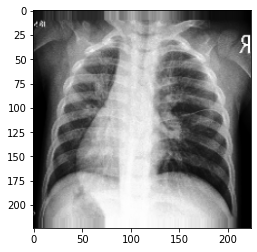

In [357]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0][0])

In [305]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *

In [ ]:
!pip install keras-tuner

In [336]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(224,224,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPool2D(
        pool_size = hp.Choice('pool_1_size', values = [3,5])
      ),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    ),

    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(3, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [337]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [338]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=20,directory='output',project_name="Covid")

INFO:tensorflow:Reloading Oracle from existing project covid_out/Covid/oracle.json
INFO:tensorflow:Reloading Tuner from covid_out/Covid/tuner0.json


In [339]:
tuner_search.search(train,epochs = 50, callbacks=[EarlyStopping(monitor='val_loss', mode='min',patience=5)], validation_data=(test))

Trial 7 Complete [00h 07m 18s]
val_accuracy: 0.9545454382896423

Best val_accuracy So Far: 0.9696969985961914
Total elapsed time: 00h 49m 19s
INFO:tensorflow:Oracle triggered exit


In [340]:
tuner_search.results_summary()

Results summary
Results in covid_out/Covid
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 3
pool_1_size: 3
conv_3_filter: 64
conv_3_kernel: 3
dense_1_units: 96
learning_rate: 0.001
Score: 0.9696969985961914
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 5
pool_1_size: 5
conv_3_filter: 32
conv_3_kernel: 5
dense_1_units: 96
learning_rate: 0.001
Score: 0.9545454382896423
Trial summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 5
pool_1_size: 3
conv_3_filter: 32
conv_3_kernel: 3
dense_1_units: 96
learning_rate: 0.001
Score: 0.9545454382896423
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 32
conv_2_kernel: 3
pool_1_size: 5
conv_3_filter: 48
conv_3_kernel: 5
dense_1_units: 112
learning_rate: 0.01
Score: 0.8939393758773804
Trial summary
Hyperp

In [341]:
model=tuner_search.get_best_models(num_models=1)[0]

In [353]:
tuner_search.get_best_models(num_models=1)

In [342]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 96)      2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 48)      41520     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        27712     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0         
_________________________________________________________________
dense (Dense)                (None, 96)                3

In [345]:
model.save('covid_best.h5')

In [348]:
model.evaluate(test)

3/3 [==============================] - 2s 364ms/step - loss: 0.2092 - accuracy: 0.9614


[0.17356543242931366, 0.9696969985961914]